# Prédiction du cours des actions d'Apple 

### L'objectif de cette partie est que si l'on connait la valeur des actions de Apple jusqu'au jour J, on peut déterminer le prix de l'action au jour J+1 et ainsi savoir si l'on doit acheter ou non.

## 0 - Préparatifs généraux

On commence par importer toutes les biblothèques nécéssaires

In [156]:
import matplotlib.pyplot as plt # Pour les graphiques
import numpy as np
import yfinance as yf # Pour extraire les données de yahoo finance
import pandas as pd # Pour manipuler des data frames
from datetime import datetime

In [157]:
input_date = "2023-12-27"

## I - Récupération des données 

Concernant la récupération des données, on a deux choix : 
Le premier est la récupération via la bibliothèque yfinance, qui récupère uniquement la valeur de fermeture des marchés

Création du "Ticker" pour Apple, nécéssaire pour extraire les données sur Yahoo Finance

In [158]:
APL = "AAPL"

In [159]:
data = yf.Ticker(APL) # Extraction avec la fonction yf.Ticker de yfinance
prix_rec = data.history(period = '1d', start = '2020-1-1', end = '2023-12-30') # On choisit une date de fin arbitraire
prix_anc = data.history(period = '1d', start = '1980-12-12', end = '2023-12-30') 

L'autre moyen est la récupération directe du CSV mis à disposition sur le site yahoo finance, que l'on enregistre sur son ordinateur.
Pour qu'il soit plus exploitable, on le transforme directement en data frame panda.

In [160]:
df=pd.read_csv("AAPL.csv")  # Passage en pandas 
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099319,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094137,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087228,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089387,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091978,73449600
...,...,...,...,...,...,...,...
10846,2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800
10847,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500
10848,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
10849,2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28877800


Il y a tout de même un léger nettoyage à faire, on ne conserve que les dates qui nous intéressent, pour ce faire on doit s'assurer que les dates sont bien en format date.

In [161]:
df['Date']=pd.to_datetime(df['Date']) # On convertit en amont toutes les dates en dates
df = df[df['Date'] >= pd.to_datetime('2020-01-01')] # Puis on ne garde qu'à partir de 2020
df

,Date,Open,High,Low,Close,Adj Close,Volume
9847,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152657,135480400
9848,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441437,146322800
9849,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018684,118387200
9850,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675270,108872000
9851,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844353,132079200
...,...,...,...,...,...,...,...
10846,2023-12-20,196.899994,197.679993,194.830002,194.830002,194.830002,52242800
10847,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500
10848,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800
10849,2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28877800


## II - Premières visualisations descriptives de la base de données

On définit cette fonction qui va nous permettre d'afficher nos séries temporelles de manière plus facile en jouant sur tous les paramètres en entrée.

In [162]:
def plot_series(time, series, format="-", start=0, end=None, label=None): 
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


### II.1 - Prix de l'action à la fermeture du marché

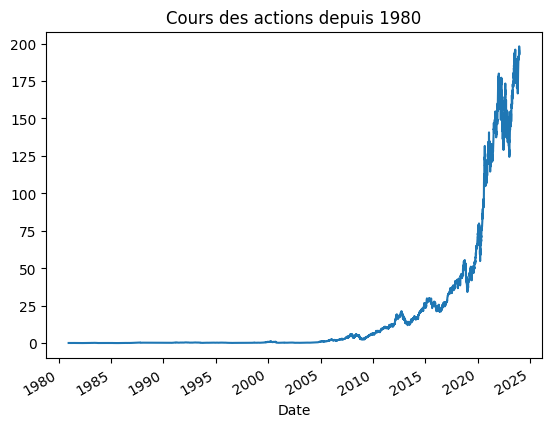

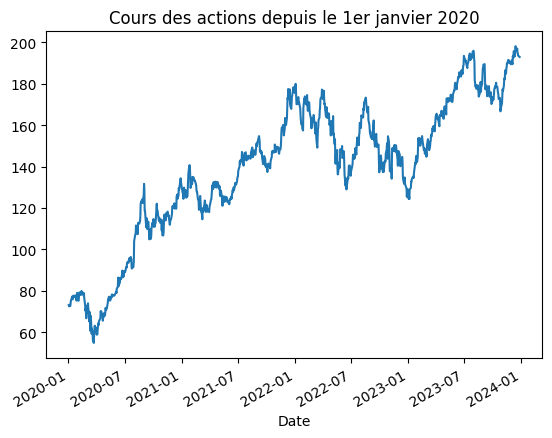

In [163]:
plt.title('Cours des actions depuis 1980')
prix_anc['Close'].plot() # Depuis 1980
plt.show()

plt.title('Cours des actions depuis le 1er janvier 2020')
prix_rec['Close'].plot() # Depuis 2020
plt.show()



### II.2 - Comparaison des valeurs de fermeture et d'ouverture

On définit des grandeurs qui vont nous servir plus tard, pour zoomer sur certaines parties par exemple. En particulier, on change la manière dont on compte le temps. Pour mieux le manipuler, on le transforme en tableau de taille correpondante au nombre de jours écoulés depuis le 2020-01-01

Pour ce faire, on a besoin d'une petite fonction car la taille du tableau va dépendre de l'input

In [164]:
time = np.arange(len(df['Close']))  # Intervalle de temps : tous les jours depuis le 2020-01-01

split_time = int(2*len(time)/3)      # Temps à partir duquel on concentre notre étude (arbitraire)

time_valid = time[split_time:] # Temps de validation du modèle 
x_valid = df['Close'][split_time:] # Partie de la courbe qui nous intéresse 

On cherche ici à voir si on peut observer des différences majeures lors de certains jours
On se concentre ici sur l'intervalle le plus récent de l'étude, à partir de 500

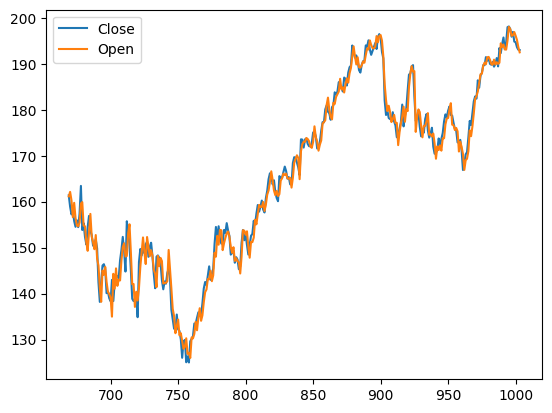

In [165]:
x_ouverture = df['Open'][split_time:] # l'analogue de x_valid avec 'Open' à la place de 'Close'

plt.plot(time_valid, x_valid, label = 'Close')
plt.plot(time_valid, x_ouverture, label = 'Open')
plt.legend()
plt.show()


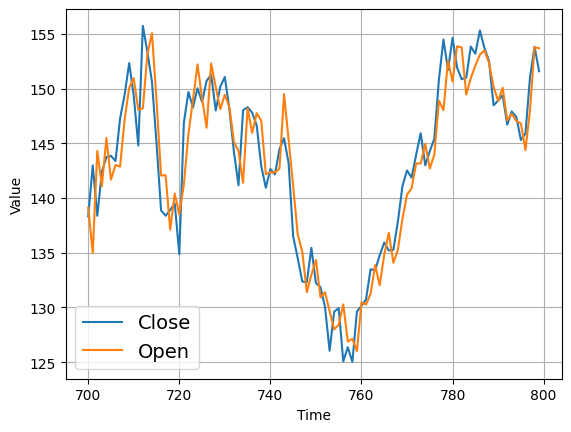

In [166]:
# On peut encore plus zoomer sur des intervalles de temps précis pour percevoir des différences certains jours

plot_series(time[700:800], df['Close'][700:800], label = 'Close')
plot_series(time[700:800], df['Open'][700:800], label = 'Open')
plt.show()

### II.3 - Comparaison des valeurs hautes et des valeurs faibles

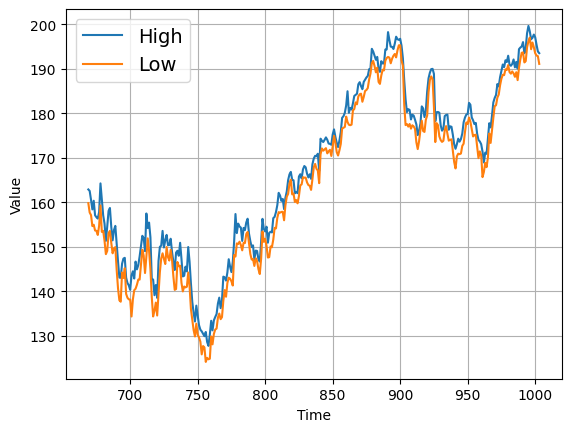

In [167]:
plot_series(time[split_time:], df['High'][split_time:], label = 'High')
plot_series(time[split_time:], df['Low'][split_time:], label = 'Low')
plt.show()

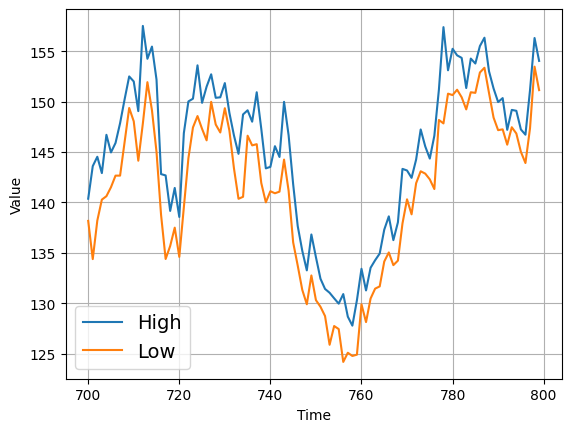

In [168]:
# En zoomant sur un passage intéressant

plot_series(time[700:800], df['High'][700:800], label = 'High')
plot_series(time[700:800], df['Low'][700:800], label = 'Low')
plt.show()

### II.4 - Volume de transaction chaque jour

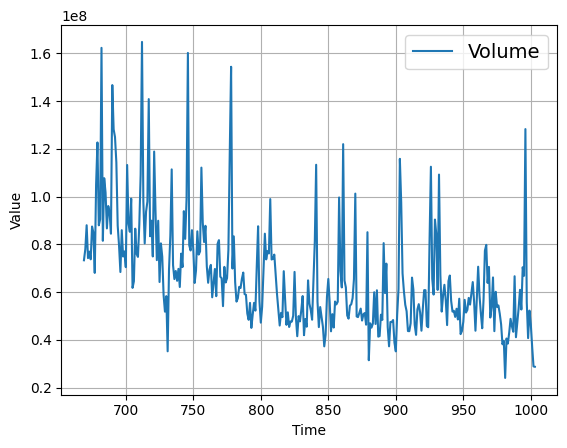

In [169]:
plot_series(time[split_time:], df['Volume'][split_time:], label = 'Volume')

## III - Modélisations pour prédire la valeur future.

In [170]:
df = df[['Date', 'Close']] # On ne garde que la variable de close qui est celle qui nous intéresse pour aller plus vite dans l'éxecution

df['NumeroLigne'] = df.reset_index().index # Pour indexer le temps, ce qui va nous servir dans le futur

/var/folders/md/_fklkl9s1z9gj6bpnwj204y40000gn/T/ipykernel_13829/4271999822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumeroLigne'] = df.reset_index().index # Pour indexer le temps, ce qui va nous servir dans le futur


On rappelle le cours de l'action à partir de la moitié du temps écoulé depuis le 01/01/2020

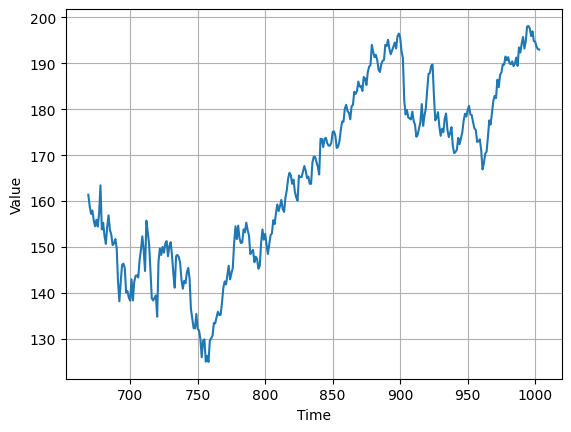

In [171]:
plot_series(time_valid, x_valid) # Visualisation du cours de l'action Apple plus récemment

## III-1 : Modèles simples, sans machine learning

### III-1.A - Moving Average / Moyennes Mouvantes

**Implémentation du modèle**

On peut implémenter notre modèle en un seul code.
Le principe du 'Moving Average' est que chaque valeur prédite par notre modèle est la moyenne des x précédentes valeurs où x est un paramètre à choisir.
Ce modèle permet une bonne prédiction mais surtout de lisser la courbe et son bruit.
Néanmoins l'erreur est supposée être assez importante comparé à des modèles plus developpés

In [172]:
def forecast_moyenne(series, window_size): # Implementation
  """La prochaine valeur est la moyenne des 'window_size' dernières valeurs"""

  forecast = [] # Crée une liste vide appelée forecast pour stocker les prévisions

  for time in range(len(series) - window_size): # On coupe à len(series) - window_size parce que sinon il n'y a plus assez de valeurs
                                                # Pour moyenner les window_size précédentes valeurs

    forecast.append(series[time:time + window_size].mean()) # Ajoute à la liste forecast la moyenne des valeurs sur l'intervalle de taille window size

  return np.array(forecast) # Convertit la liste forecast en un tableau numpy et le renvoie
                            # Ainsi on pourra l'exploiter par la suite

On crée alors notre tableau avec les valeurs modélisées par notre modèle

In [173]:
prix_forecast = forecast_moyenne(df['Close'], 30)[split_time - 30:] # Prédiction de la valeur du prix

# On commence en avance par rapport au temps qui nous intéresse pour pouvoir avoir 'window_size' de temps déja connus
# Ainsi on pourra faire la moyenne des 'window_size' (ici 30) précédentes valeurs pour que à partir de 'split_time'
# les valeurs soient uniquement des valeurs crées par notre modèle 

Première visualisation du résultat obtenu.

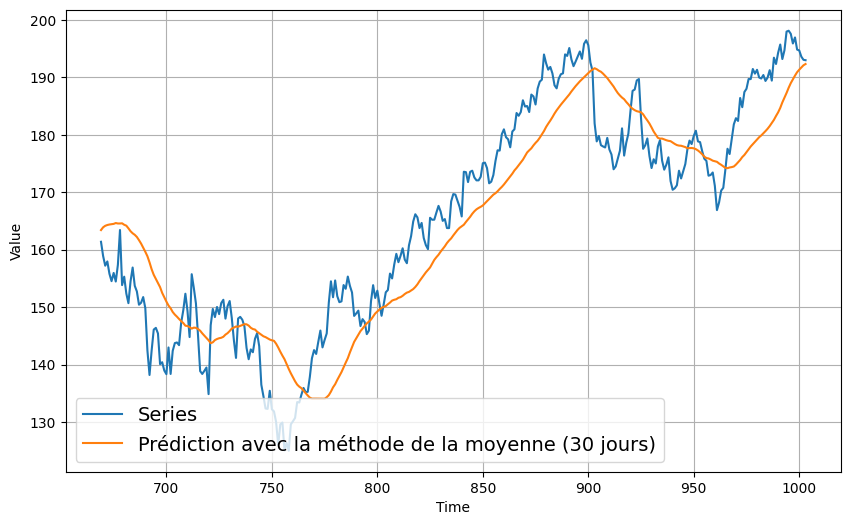

In [174]:
plt.figure(figsize=(10, 6)) # On compare 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")

Le résultat est assez satisfaisant, on obtient une belle courbe qui capte bien les variations du cours de l'action.

Essayons de faire varier la fenêtre pour obtenir un modèle plus précis.

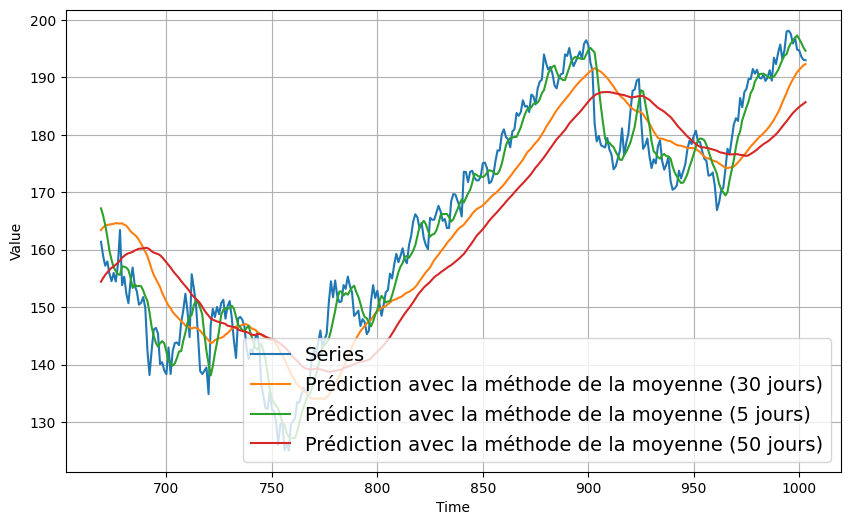

In [175]:
prix_forecast5 = forecast_moyenne(df['Close'], 5)[split_time - 5:]
prix_forecast50 = forecast_moyenne(df['Close'], 50)[split_time - 50:]

plt.figure(figsize=(10, 6)) # On compare 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")
plot_series(time_valid, prix_forecast5, label = "Prédiction avec la méthode de la moyenne (5 jours)")
plot_series(time_valid, prix_forecast50, label = "Prédiction avec la méthode de la moyenne (50 jours)")

On comprend dans ce cas précis que le moins on prend de valeurs dans la fenêtre dont on fait la moyenne, et le plus sera précise notre prédiction.

### III-1.B - Naive forecast

Après avoir remarqué cela, on s'attaque ici dans un second temps à un second modèle sans machine learning.
Il s'agit du modèle de prévision naive où 'Naive Forecast' en anglais.
Le concept du modèle est que chaque valeur de notre modèle est la valeur à la date précédente de la courbe de base. On peut considérer cela comme un modèle de Moving Average avec une window size égale à 1.

Le modèle est donc très efficace pour les modèles qui ne sont pas soumis à d'énormes variations.

**Implémentation du modèle**

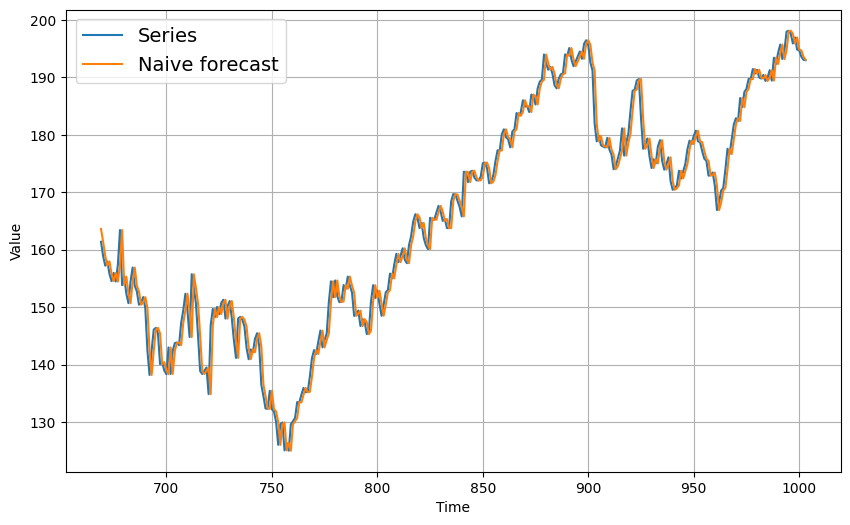

In [176]:
naive_forecast = df['Close'][split_time - 1:-1] # Avec le naive forecast

# Le naive forecast consiste à prédire chaque valeur par la valeur précedente du modèle
# Ici on commence donc à la valeur qui précède l'intervalle qui nous intéresse jusqu'à la fin

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label= "Naive forecast")

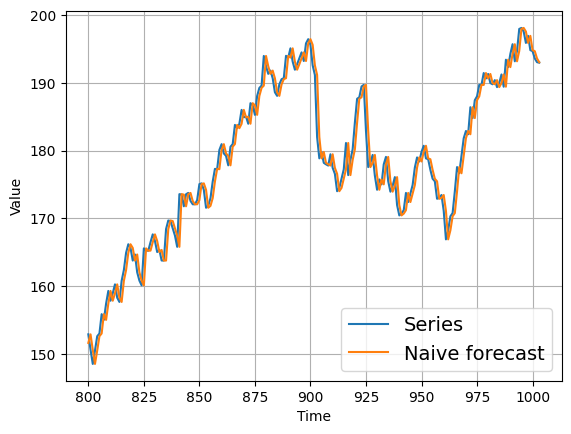

In [177]:
# On zoom sur l'efficacité du naive forecast 

split_time2 = 800
time_naive = time[split_time2:]
x_naive = df['Close'][split_time2:]
naive_forecast2 = df['Close'][split_time2 - 1:-1]
plot_series(time_naive, x_naive, label="Series")
plot_series(time_naive, naive_forecast2, label="Naive forecast")

### III-1.C - Comparaison des deux modèles

Superposons les deux modèles avant de comparer leurs erreurs respectives

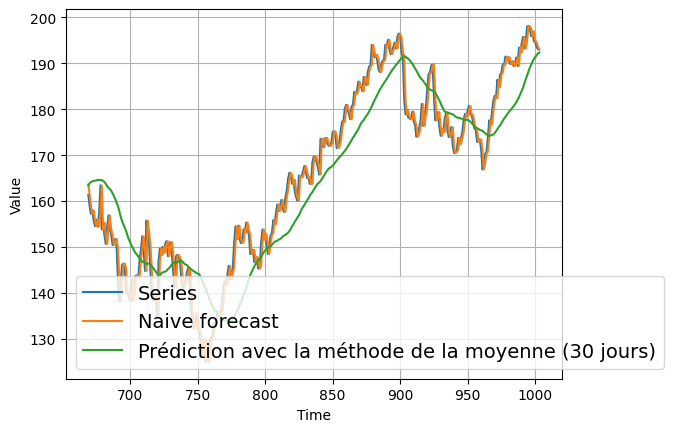

In [178]:
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label= "Naive forecast")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")

Comparaison des erreurs des modèles

In [213]:
# Erreur des modèles 
import tensorflow as tf 

# Naive forecast 
erreur_naif = tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy() # On utilise le module d'erreurs de la librairie tensorflow
print(f"L'erreur du modèle naif est : {erreur_naif}")
# Mean Absolute Error : différence moyenne absolue

# Forecast moyen 
erreur_30j = tf.keras.metrics.mean_absolute_error(x_valid, prix_forecast).numpy() # On utilise le module d'erreurs de la librairie tensorflow
print(f"L'erreur du modèle de moving average sur 30 jours est : {erreur_30j}")

L'erreur du modèle naif est : 1.9403583492537313
L'erreur du modèle de moving average sur 30 jours est : 6.921465552537312


Le modèle de naive forecast est très efficace ici, tandis que l'erreur du modèle de moving average est assez importante. 
On peut tout de même essayer d'aller plus loin à l'aide d'un modèle faisant appel a du machine learning !

## III-2 - Modélisation avec du machine learning, modèle LSTM

### III-2.A : Préparation pour faire fonctionner le modèle

Le but du modèle choisi, modèle LSTM (Long short-term memory) est de garder quelques valeurs précedentes en mémoire pour prédire la prochaine valeur avec une manière de prédire plus complexe qu'une relation linéaire ou de moyenne.

On commence alors par créer une fonction qui va nous renvoyer notre dataframe avec des colonnes ajoutées : à savoir les valeurs de 'Close' aux 4 jours qui suivent notre date. La quatrième valeur est appelée "Target". Target est ainsi la valeur à T+4 de 'Close'

In [180]:
# On commence par définir nos décalages qui vont nous permettre de prendre les valeurs du futur 
shifts=[-1, -2, -3, -4]

In [181]:

def add_shifted_columns(df, shifts):
  
  for index, Target in enumerate(shifts): # On conserve l'index car il nous servira
                                             # On boucle sur toutes les valeurs pour ajouter toutes les colonnes

    df_temp=df['Close'].shift(Target) # Utilisation de la fonction shift de panda : 
                                         # df.['Close].shift[-1] renvoie la valeur suivante de Close (par rapport au temps dans la boucle)
    if index<(len(shifts)-1):
      col_name=f'Target - {index+1}' # On crée le nom de colonne Target - n (on réequilibre l'index qui commençait à 0)

    else:
      col_name='Target' # Si on est au bout de la liste de décalages, alors on a atteint notre target

    df[col_name]=df_temp # On ajoute la colonne avec son nouveau nom à notre tableau final à l'aide de notre tableau temporaire

    df['Target Date']=df['Date'].shift(-len(shifts)) # On ajoute la date associée au Target final

  return df


In [182]:
# Testons le résultat

df = add_shifted_columns(df,shifts)
df

/var/folders/md/_fklkl9s1z9gj6bpnwj204y40000gn/T/ipykernel_13829/1213912355.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name]=df_temp # On ajoute la colonne avec son nouveau nom à notre tableau final à l'aide de notre tableau temporaire
/var/folders/md/_fklkl9s1z9gj6bpnwj204y40000gn/T/ipykernel_13829/1213912355.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target Date']=df['Date'].shift(-len(shifts)) # On ajoute la date associée au Target final
/var/folders/md/_fklkl9s1z9gj6bpnwj2

,Date,Close,NumeroLigne,Target - 1,Target Date,Target - 2,Target - 3,Target
9847,2020-01-02,75.087502,0,74.357498,2020-01-08,74.949997,74.597504,75.797501
9848,2020-01-03,74.357498,1,74.949997,2020-01-09,74.597504,75.797501,77.407501
9849,2020-01-06,74.949997,2,74.597504,2020-01-10,75.797501,77.407501,77.582497
9850,2020-01-07,74.597504,3,75.797501,2020-01-13,77.407501,77.582497,79.239998
9851,2020-01-08,75.797501,4,77.407501,2020-01-14,77.582497,79.239998,78.169998
...,...,...,...,...,...,...,...,...
10846,2023-12-20,194.830002,999,194.679993,2023-12-27,193.600006,193.050003,192.979996
10847,2023-12-21,194.679993,1000,193.600006,NaT,193.050003,192.979996,NaN
10848,2023-12-22,193.600006,1001,193.050003,NaT,192.979996,NaN,NaN
10849,2023-12-26,193.050003,1002,192.979996,NaT,NaN,NaN,NaN


In [183]:
# On replace Target Date au sein du tableau pour plus d'esthétique
ordre_colonnes = ['Date', 'Close', 'Target Date', 'Target - 1', 'Target - 2', 'Target - 3', 'Target']
df = df[ordre_colonnes]

On rappelle que l'existence de trous entre les dates est liée à la fermeture des marchés pendant les week-ends.

On entre plus en profondeur dans la modélisation, ainsi la date originale et la valeur originale de Close ne nous intéressent plus, il vient :

In [184]:
df=df.drop(['Date', 'Close'],axis=1) 

Par la suite, il faut aussi transformer le format de nos paramètres pour qu'ils conviennent à l'utilisation d'un modèle LSTM.
On crée une fonction qui va diviser en 3 catégories nos variables, (Date, Targets - n, Target) et les mettre au bon format.

Il s'agit d'adapter la forme des caractéristiques à une forme qui convient à l'entrée d'un modèle LSTM.

In [185]:
def formatage(df):

    # On commence par les dates 
    dates = df.iloc[:, 0].values

    # Puis les Targets intermédiaires 
    X = df.iloc[:, 1:-1].values.reshape(-1, df.shape[1] - 2, 1).astype(np.float32)

    # -1 : réorganiser les données tout en conservant le même nombre total d'éléments (convention)

    # df.shape[1] - 2 : la nouvelle taille de la deuxième dimension (nombre de colonnes)
                       # Donc ici on garde le nombre de Target intermédiaire en retirant Date et Target Final

    # 1 : Taille de la troisème dimension : représentation d'une série temporelle univariée

    # Et enfin on met le Target au bon format
    Y = df.iloc[:, -1].values.astype(np.float32)

    # De nombreux modèles préfèrent travailler avec des données en virgule flottante 32 bits 
    # plutôt qu'avec des types de données plus larges.

    return dates, X, Y


In [186]:
# On applique à notre data frame 

dates, X, Y = formatage(df) # X représente les Targets Intermédiaires, Y le Target Final

dates.shape, X.shape, Y.shape

((1004,), (1004, 3, 1), (1004,))

Maintenant que nos trois variables, 'dates', 'X' et 'Y' sont au bon format, il y a un autre prérequis au bon fonctionnement d'un modèle LSTM.
Il s'agit de la définition des périodes d'entraînement du modèle, de validation puis de test.
Comme nos variables sont désormées "formatées", elles sont beaucoup plus faciles à utiliser.

In [187]:
def train_val_test(dates, X, Y, train_ratio, val_ratio): # On connaît maintenant les formats des objets pour les découper

    train_index = int(len(dates) * train_ratio) # Nombre de dates sur lesquelles on va s'entraîner
    val_index = train_index + int(len(dates) * val_ratio) # Nombre de dates sur lesquelles on s'entraîne et on valide

    dates_train, X_train, Y_train = dates[:train_index], X[:train_index], Y[:train_index] # Période d'entraînement

    dates_val, X_val, Y_val = dates[train_index:val_index], X[train_index:val_index], Y[train_index: val_index] # Période de validation
    # (qui justifie la définition de val_index)

    dates_test, X_test, Y_test = dates[val_index:], X[val_index:], Y[ val_index:] # Période de test

    return (dates_train, X_train, Y_train), (dates_val, X_val, Y_val), (dates_test, X_test, Y_test)


In [188]:
# On applique à nos dates 

(dates_train, X_train, Y_train), (dates_val, X_val, Y_val), (dates_test, X_test, Y_test) = train_val_test(dates, X, Y, 0.8,0.1)

# On définit 80% d'entrainement, 10% de validation et 10% de test pour notre modèle

Visualisons alors sur notre courbe originale les périodes d'entraînement, de validation et de test du modèle.

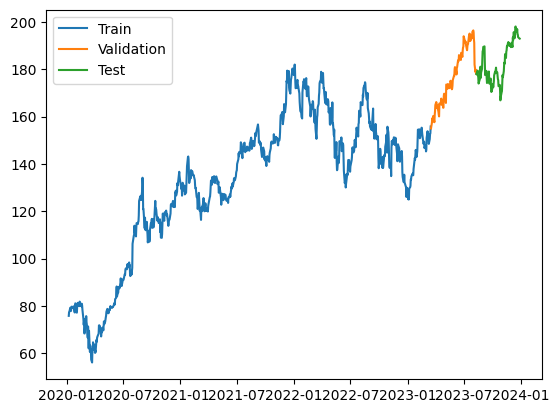

In [189]:
plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)

plt.legend(['Train', 'Validation', 'Test']) # Il s'agit en fait de trois courbes 

### III-2.B : Implémentation du modèle

Il est alors l'heure d'expliciter le modèle maintenant que les préparatifs sont prêts. 
Il s'agit comme dit précedemment d'un modèle LSTM qui s'implémente sous la forme suivante :

In [190]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


Maintenant, on entraîne le modèle sur l'intervalle qu'on lui a consacré pour son entraînement

In [215]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100)

Epoch 1/100
26/26 [==============================] - 0s 2ms/step - loss: 8.3450 - mean_absolute_error: 2.1745 - val_loss: 28.5545 - val_mean_absolute_error: 4.0204
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 7.8866 - mean_absolute_error: 2.1345 - val_loss: 36.1821 - val_mean_absolute_error: 4.8048
Epoch 3/100
26/26 [==============================] - 0s 1ms/step - loss: 8.7620 - mean_absolute_error: 2.2832 - val_loss: 24.6792 - val_mean_absolute_error: 3.7035
Epoch 4/100
26/26 [==============================] - 0s 1ms/step - loss: 9.2842 - mean_absolute_error: 2.3270 - val_loss: 24.5494 - val_mean_absolute_error: 3.7649
Epoch 5/100
26/26 [==============================] - 0s 1ms/step - loss: 7.8980 - mean_absolute_error: 2.0971 - val_loss: 30.5569 - val_mean_absolute_error: 4.1771
Epoch 6/100
26/26 [==============================] - 0s 1ms/step - loss: 8.6050 - mean_absolute_error: 2.2271 - val_loss: 23.8531 - val_mean_absolute_error: 3.6499
Epoch 7/100
26/2

Avec 100 epochs, il semblerait que l'erreur entre la modélisation et la réalité de la période de validation stagne rapidement, et qu'il n'est pas nécéssaire de s'entrainer autant. Vérifions cela avec des courbes.

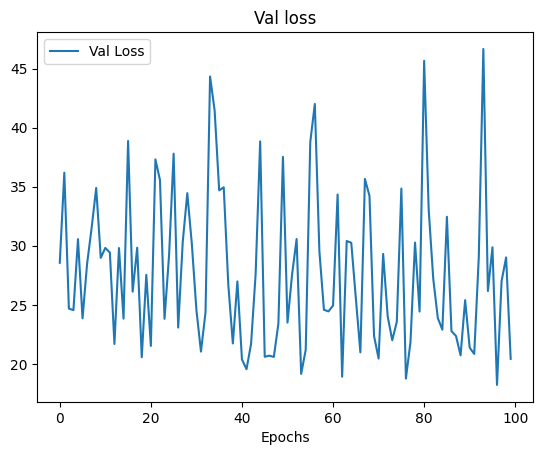

In [216]:
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Val loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Il semble en effet que le modèle souffre d'overfitting.

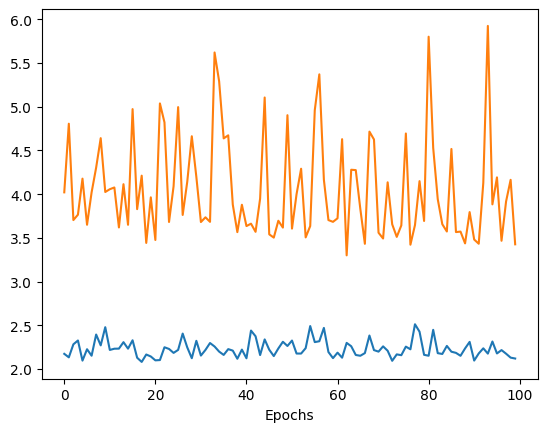

In [217]:
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
plt.xlabel('Epochs')
plt.show()

De même avec les autres indicateurs. Il faut donc réussir à arrêter l'entrainement du modèle au bon moment.


Nous allons alors implementer de l'EarlyStopping pour que le modèle s'arrête lorsqu'il ne s'améliore plus, voire se détériore.

In [218]:
from keras.callbacks import EarlyStopping # On importe la méthode

In [219]:
# Puis on la configure
early_stopping = EarlyStopping(
    monitor='val_loss',  # la métrique à surveiller : on ne veut pas que l'erreur de la période de validation ne remonte
    min_delta=0.001,     # changement minimum pour être considéré comme une amélioration
    patience=10,         # nombre d'epochs sans amélioration après lesquelles l'entraînement sera arrêté
    verbose=1,           # pour afficher des messages
    mode='auto' )         # le mode peut être 'auto', 'min', ou 'max'

In [220]:
# On ajoute ça à notre modèle

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, callbacks=[early_stopping])

Epoch 1/100
26/26 [==============================] - 0s 2ms/step - loss: 7.7321 - mean_absolute_error: 2.0836 - val_loss: 27.6775 - val_mean_absolute_error: 4.0620
Epoch 2/100
26/26 [==============================] - 0s 1ms/step - loss: 9.0659 - mean_absolute_error: 2.2809 - val_loss: 29.1411 - val_mean_absolute_error: 4.1986
Epoch 3/100
26/26 [==============================] - 0s 1ms/step - loss: 9.3540 - mean_absolute_error: 2.3787 - val_loss: 32.8284 - val_mean_absolute_error: 4.5749
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 9.5336 - mean_absolute_error: 2.3701 - val_loss: 24.5970 - val_mean_absolute_error: 3.7036
Epoch 5/100
26/26 [==============================] - 0s 1ms/step - loss: 8.2479 - mean_absolute_error: 2.1697 - val_loss: 28.4233 - val_mean_absolute_error: 4.0388
Epoch 6/100
26/26 [==============================] - 0s 1ms/step - loss: 8.4488 - mean_absolute_error: 2.1858 - val_loss: 25.6594 - val_mean_absolute_error: 3.8110
Epoch 7/100
26/2

Maintenant que notre modèle s'est entraîné, il est l'heure de voir si son entraînement a été efficace

I - 3 : Visualisation du modèle

26/26 [==============================] - 0s 533us/step


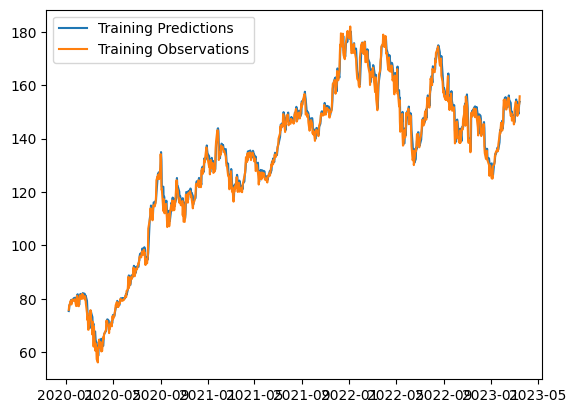

In [221]:
# Intervalle d'entraînement 

train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 786us/step


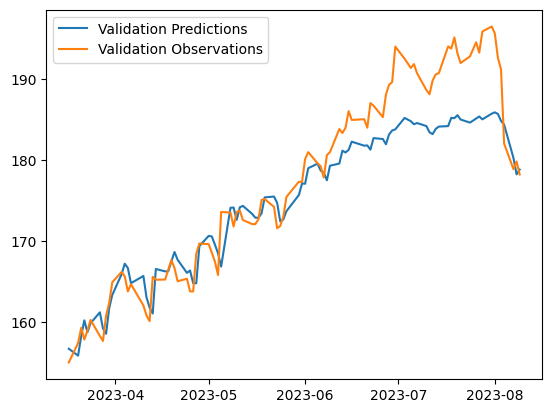

In [222]:
# De même avec la période de validation 

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 781us/step


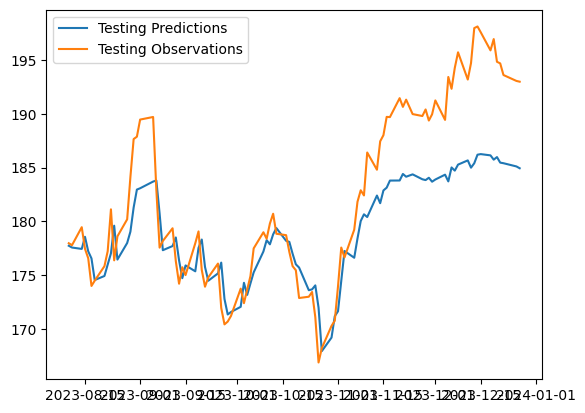

In [223]:
# Et enfin sur la partie de tests :

test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

On peut essayer de tout regrouper pour avoir une vue d'ensemble de notre modèle comparé à la réalité !

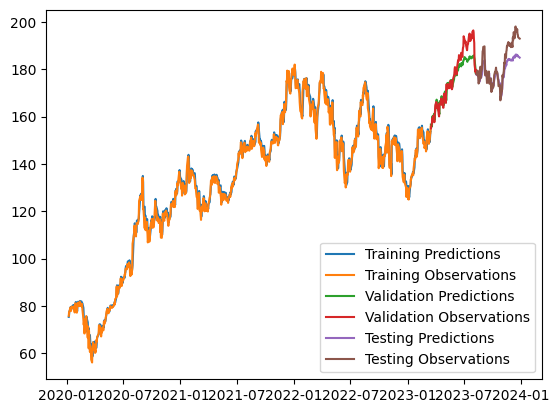

In [224]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

### III-2.C Erreurs du modèle

In [225]:
import tensorflow as tf

In [226]:
print(tf.keras.metrics.mean_absolute_error(train_predictions, Y_train).numpy())
print(tf.keras.metrics.mean_absolute_error(val_predictions, Y_val).numpy())

2.1242561
3.406266


L'erreur est assez faible, logiquement, sur ses périodes d'entraînement et de validation.
Intéressons nous désormais à l'erreur du modèle sur sa période de test

En raison du modèle que nous avons utilisé, avec le système de 'Target', il se crée 4 futures dates (ici appelées NaN autoamtiquement du coup), qui apparaissent dans dates_test

In [227]:
print(dates_test)

['2023-08-10T00:00:00.000000000' '2023-08-11T00:00:00.000000000'
 '2023-08-14T00:00:00.000000000' '2023-08-15T00:00:00.000000000'
 '2023-08-16T00:00:00.000000000' '2023-08-17T00:00:00.000000000'
 '2023-08-18T00:00:00.000000000' '2023-08-21T00:00:00.000000000'
 '2023-08-22T00:00:00.000000000' '2023-08-23T00:00:00.000000000'
 '2023-08-24T00:00:00.000000000' '2023-08-25T00:00:00.000000000'
 '2023-08-28T00:00:00.000000000' '2023-08-29T00:00:00.000000000'
 '2023-08-30T00:00:00.000000000' '2023-08-31T00:00:00.000000000'
 '2023-09-01T00:00:00.000000000' '2023-09-05T00:00:00.000000000'
 '2023-09-06T00:00:00.000000000' '2023-09-07T00:00:00.000000000'
 '2023-09-08T00:00:00.000000000' '2023-09-11T00:00:00.000000000'
 '2023-09-12T00:00:00.000000000' '2023-09-13T00:00:00.000000000'
 '2023-09-14T00:00:00.000000000' '2023-09-15T00:00:00.000000000'
 '2023-09-18T00:00:00.000000000' '2023-09-19T00:00:00.000000000'
 '2023-09-20T00:00:00.000000000' '2023-09-21T00:00:00.000000000'
 '2023-09-22T00:00:00.000

Ainsi, à chacune de ces dates est associée la valeur réelle de l'action, et comme les valeurs futures ne sont pas dans le modèle de base, la valeur affichée est nan.

In [228]:
print(Y_test)

[177.97 177.79 179.46 177.45 176.57 174.   174.49 175.84 177.23 181.12
 176.38 178.61 180.19 184.12 187.65 187.87 189.46 189.7  182.91 177.56
 178.18 179.36 176.3  174.21 175.74 175.01 177.97 179.07 175.49 173.93
 174.79 176.08 171.96 170.43 170.69 171.21 173.75 172.4  173.66 174.91
 177.49 178.99 178.39 179.8  180.71 178.85 178.72 177.15 175.84 175.46
 172.88 173.   173.44 171.1  166.89 168.22 170.29 170.77 173.97 177.57
 176.65 179.23 181.82 182.89 182.41 186.4  184.8  187.44 188.01 189.71
 189.69 191.45 190.64 191.31 189.97 189.79 190.4  189.37 189.95 191.24
 189.43 193.42 192.32 194.27 195.71 193.18 194.71 197.96 198.11 197.57
 195.89 196.94 194.83 194.68 193.6  193.05 192.98    nan    nan    nan
    nan]


Cependant, notre modèle de prédiction a crée une valeur pour la date qui suit l'extraction du fichier (ici le 27 décembre), et ne comporte donc plus que 3 dates sans valeur associée

In [229]:
print(test_predictions)

[177.73718 177.56958 177.44202 178.56862 177.21588 176.55972 174.55124
 174.92728 175.98712 177.02478 179.59952 176.4523  177.99039 179.0434
 181.29092 182.95502 183.07785 183.69861 183.80042 180.73764 177.32242
 177.70845 178.5074  176.37732 174.7207  175.90805 175.3616  177.53842
 178.31494 175.76215 174.48334 175.16846 176.17087 172.79237 171.34988
 171.5787  172.06133 174.29468 173.16724 174.23141 175.26239 177.20085
 178.25714 177.86708 178.79376 179.37729 178.19391 178.08911 176.99417
 176.01163 175.70998 173.6042  173.6822  174.05428 171.98538 167.94168
 169.20297 171.18637 171.65285 174.47157 177.24811 176.6207  178.40675
 180.03198 180.65848 180.40298 182.40128 181.68976 182.87419 183.13295
 183.79169 183.79886 184.40753 184.14998 184.36945 183.91339 183.83759
 184.05327 183.6866  183.89032 184.34048 183.7157  185.0119  184.71414
 185.27478 185.66684 184.99066 185.40057 186.196   186.25082 186.13382
 185.7353  185.97556 185.45943 185.40485 185.10501 184.937   184.91199
       

Pour calculer l'erreur moyenne selon la méthode mean absolute error du modèle sur la partie test, nous allons devoir nous débarasser des 'nan'.

In [230]:
# Ainsi on cherche d'abord les indices dont se débarasser 
nan_indices_test_predictions = np.isnan(test_predictions)
print("Indices des valeurs nan dans test_predictions:", np.where(nan_indices_test_predictions)[0])

nan_indices_Y_test = np.isnan(Y_test)
print("Indices des valeurs nan dans Y_test:", np.where(nan_indices_Y_test)[0])

Indices des valeurs nan dans test_predictions: [ 98  99 100]
Indices des valeurs nan dans Y_test: [ 97  98  99 100]


Et on calcule l'erreur de notre modèle comparé à la réalité :

In [231]:
premier_nan =  np.where(nan_indices_Y_test)[0][0] # la première date manquante dans nos dates de la période de test

In [232]:
print(tf.keras.metrics.mean_absolute_error(test_predictions[:premier_nan], Y_test[:premier_nan]).numpy())

3.862036


### III-2.D - Conclusion sur le choix du modèle

Avec le modèle LTSM, on obtient toujours une erreur plus importante que sur un modèle simple tel que le naive forecasting.

Ainsi, pour déterminer la valeur de l'action demain, nous allons nous fier à la valeur donnée par le modèle de naive forecasting plutôt que la valeur donnée par le modèle LSTM

## IV - Prédiction de la valeur future

Il est maintenant temps de conclure. Le modèle retenu est le modèle de naive forecasting.

Il faut maintenant déterminer s'il faut acheter l'action ou non. En raison des propriétés du modèle de naive forecasting, la valeur prédite au jour J+1 sera la valeure réelle au jour J, c'est à dire la veleur réelle de l'action le jour de l'input

In [208]:
### A voir si on prend J+2. pour naive forecast..


In [209]:
# Sinon, si on veut quand même utiliser le LSTM :

Ainsi, pour tout de même utiliser notre modèle LSTM, on peut s'intéresser à la valeur prédite même si elle est théoriquement plus éloignée de la réalité que ce donne le modèle du naive forecasting

In [233]:
indice_prediction = np.where(nan_indices_Y_test)[0][0] # Indice de la valeur ou le modèle a crée une valeur


C'est la première date à partir de laquelle la courbe de base n'a pas de valeur de prix associée, c'est donc une date à laquelle le modèle va associer une prédiction.
La voici.


In [234]:
valeur_prediction = test_predictions[indice_prediction]
valeur_prediction

184.91199

Il s'agit alors de comparer avec la valeur précedente, et dire si on achète ou non :

In [235]:
def acheter_ou_non():
   if valeur_prediction > test_predictions[indice_prediction-1]:
      return 'ACHETER'
   else:
      return 'NE PAS ACHETER'

acheter_ou_non()

'NE PAS ACHETER'